###Решить NLP задачу и использованием стандартных представлений документов (BOW, Tf-Idf).

Датасет: https://www.kaggle.com/c/stumbleupon


In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import normaltest
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,  GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, precision_score, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

## Вспомогательные функции

In [ ]:
## Просмотр данных
def prosmotr(data):
  pd.set_option('display.max_columns', 100) #Размеры таблицы
  pd.set_option('display.max_rows', 100)
  pd.set_option('precision', 2) #Регулируем количество знаков после запятой:
  print('~~~~Содержание данных~~~~\n', data.head())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Размеры данных~~~\n', data.shape)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Названия колонок~~~\n', data.columns)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Информация о данных~~~\n')
  print(data.info())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Наличие пропусков в данных~~~\n', data.isna().sum())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Количество типов в данных~~~')
  print(data.dtypes.value_counts())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  kateg = list(data.select_dtypes(include=['object']).columns) # Делаем список категориальных данных
  print('~~~Категориальные данные~~~~')
  print(kateg)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  chislov_float = list(data.select_dtypes(include=['float64'])) #Делаем список числовых данных float
  print('~~~Числове данные float~~~~')
  print(chislov_float)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  chislov_int = list(data.select_dtypes(include=['int64'])) #Делаем список числовых данных int
  print('~~~Числове данные int~~~~')
  print(chislov_int)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Основные статистические характеристики данных по каждому числовому признаку (типы int64)~~~\n', data.describe(include=['int64']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Основные статистические характеристики данных по каждому числовому признаку (типы float64)~~~\n', data.describe(include=['float64']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  

In [ ]:
## Анализ данных
def analyze(data):
  num = data.columns
  for i in num:
    print(i.title())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~\n')
    print("mean : ", np.mean(data[i]))
    print("var  : ", np.var(data[i]))
    print("skew : ", skew(data[i]))
    print("kurt : ", kurtosis(data[i]))
    print("shapiro : ", shapiro(data[i]))
    print("normaltest : ", normaltest(data[i]))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~\n')

In [ ]:
# метрика
def value_of_metrics(y_true, y_pred):
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Recall: ', recall_score(y_true, y_pred))
    print('Precision: ', precision_score(y_true, y_pred))  
    print('F1: ', f1_score(y_true, y_pred))
    print('Roc_AUC: ', roc_auc_score(y_true, y_pred))
    
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('My DataSet')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
def text_preprocess(text):    
    reg = re.compile('[^а-яА-Яa-zA-Z0-9]') #
    text = text.lower()
    text = reg.sub(' ', text)
    lemmatizer = WordNetLemmatizer()
    text_ =''
    for word in text.split():
        #text_.append(lemmatizer.lemmatize(word))
        text_ = text_+ ' ' + lemmatizer.lemmatize(word)
    return text_

## По алгоритмам

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


def fit_model(model, X, y, parameters):  
  cross_validation = StratifiedKFold(n_splits=5)

  grid_search = GridSearchCV(model,
                              scoring='accuracy',
                              param_grid=parameters,
                              cv=cross_validation,
                              verbose=1
                            )

  grid_search.fit(X, y)
  parameters=grid_search.best_params_
  print('Best score: {}'.format(grid_search.best_score_))
  print('Best parameters: {}'.format(parameters))

  return grid_search

## BAYES

In [ ]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB


def Bern(train, targets):
  parameter_grid = {
                 'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 1.0],
                 'binarize': [0.0, 0.2, 0.5],
                 'fit_prior': ['True', 'False']
                 }
  bernoulli = BernoulliNB()
  trained_bernoulli = fit_model(bernoulli, train, targets, parameter_grid)
  return trained_bernoulli

def Gaus(train, targets):
  gaussian_nb = GaussianNB()
  parameter_grid = {
                 'var_smoothing': [1e-09, 1e-10, 1e-11, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
                 }
  trained_gaussian_nb = fit_model(gaussian_nb, train, targets, parameter_grid)
  return trained_gaussian_nb

def Multi_nb(train, targets):
  multi_nb = MultinomialNB()
  parameter_grid = {
                 'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 1.0],
                 'fit_prior': ['True', 'False']
                 }
  trained_multi_nb = fit_model(multi_nb, train, targets, parameter_grid)
  return trained_multi_nb

def Complement_nb(train, targets):
  complement_nb = ComplementNB()
  parameter_grid = {
                 'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 1.0],
                 'fit_prior': ['True', 'False'],
                 'norm': ['True', 'False']
                 }
  trained_complement_nb = fit_model(complement_nb, train, targets, parameter_grid)
  return trained_complement_nb


## Загрузка данных

In [ ]:
file = files.upload()

Saving train.tsv to train.tsv


In [ ]:
data = pd.read_csv("train.tsv", sep ='\t')

In [ ]:
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [ ]:
prosmotr(data)

~~~~Содержание данных~~~~
                                                  url  urlid  \
0  http://www.bloomberg.com/news/2010-12-23/ibm-p...   4042   
1  http://www.popsci.com/technology/article/2012-...   8471   
2  http://www.menshealth.com/health/flu-fighting-...   1164   
3  http://www.dumblittleman.com/2007/12/10-foolpr...   6684   
4  http://bleacherreport.com/articles/1205138-the...   9006   

                                         boilerplate alchemy_category  \
0  {"title":"IBM Sees Holographic Calls Air Breat...         business   
1  {"title":"The Fully Electronic Futuristic Star...       recreation   
2  {"title":"Fruits that Fight the Flu fruits tha...           health   
3  {"title":"10 Foolproof Tips for Better Sleep "...           health   
4  {"title":"The 50 Coolest Jerseys You Didn t Kn...           sports   

  alchemy_category_score  avglinksize  commonlinkratio_1  commonlinkratio_2  \
0               0.789131         2.06               0.68               0.21 

In [ ]:
data['boilerplate'].iloc[0]

'{"title":"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries","body":"A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose California Photographer Tony Avelar Bloomberg By 2015 your mobile phone will project a 3 D image of anyone who calls and your laptop will be powered by kinetic energy At least that s what International Business Machines Corp sees in its crystal ball The predictions are part of an annual tradition for the Armonk New York based company which surveys its 3 000 researchers to find five ideas expected to take root in the next five years IBM the world s largest provider of computer services looks to Silicon Valley for input gleaning many ideas from its Almaden research center in San Jose

In [ ]:
dt=data[['boilerplate','label']]
dt.head()

,boilerplate,label
0,"{""title"":""IBM Sees Holographic Calls Air Breat...",0
1,"{""title"":""The Fully Electronic Futuristic Star...",1
2,"{""title"":""Fruits that Fight the Flu fruits tha...",1
3,"{""title"":""10 Foolproof Tips for Better Sleep ""...",1
4,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",0


In [ ]:
dt['label'].value_counts()

1    3796
0    3599
Name: label, dtype: int64

In [ ]:
dt.shape

(7395, 2)

In [ ]:
dt['boilerplate'] = dt['boilerplate'].apply(text_preprocess)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dt['boilerplate'].head()

0     title ibm see holographic call air breathing ...
1     title the fully electronic futuristic startin...
2     title fruit that fight the flu fruit that fig...
3     title 10 foolproof tip for better sleep body ...
4     title the 50 coolest jersey you didn t know e...
Name: boilerplate, dtype: object

## Bag of WORDS

In [ ]:
X = dt['boilerplate']
y = dt['label']
cv = CountVectorizer() # Bag of WORDS (BOW)
X = cv.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)

In [ ]:
X_train.shape

(5546, 84521)

In [ ]:
X_test.shape

(1849, 84521)

## Алгоритмы

In [ ]:
## BAYS
bern_train = Bern(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score: 0.7668589974756581
Best parameters: {'alpha': 0.001, 'binarize': 0.0, 'fit_prior': 'True'}


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    5.8s finished


Accuracy:  0.7582477014602488
Recall:  0.6024498886414253
Precision:  0.8573692551505546
F1:  0.7076520601700458
Roc_AUC:  0.753906332333331


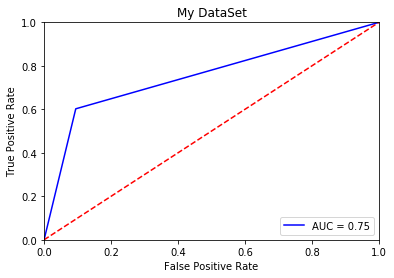

In [ ]:
value_of_metrics(y_test,bern_train.predict(X_test))

In [ ]:
## Multi
multu_train = Multi_nb(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score: 0.8103137396321674
Best parameters: {'alpha': 0.1, 'fit_prior': 'True'}


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.2s finished


Accuracy:  0.8134126554894537
Recall:  0.7427616926503341
Precision:  0.8540332906530089
F1:  0.7945205479452055
Roc_AUC:  0.8114439378078169


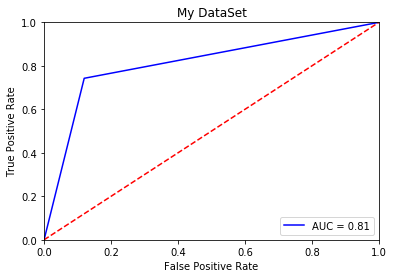

In [ ]:
value_of_metrics(y_test,multu_train.predict(X_test))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [ ]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy:  0.7577068685776095
Recall:  0.7305122494432071
Precision:  0.7610208816705336
F1:  0.7454545454545454
Roc_AUC:  0.756949079506041


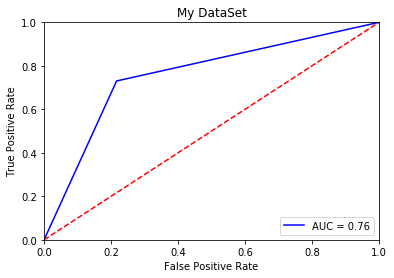

In [ ]:
value_of_metrics(y_test,logit.predict(X_test))

In [ ]:
svm = LinearSVC()
svm.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Accuracy:  0.7122769064359114
Recall:  0.7126948775055679
Precision:  0.700218818380744
F1:  0.7064017660044151
Roc_AUC:  0.7122885533689775


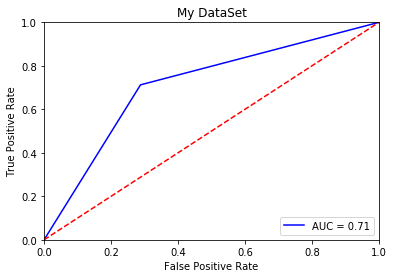

In [ ]:
value_of_metrics(y_test,svm.predict(X_test))

## Tfid

In [ ]:
X = dt['boilerplate']
y = dt['label']
cv = TfidfVectorizer()
X = cv.fit_transform(X)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=47)

## Алгоритмы

In [ ]:
## BAYS
bern_train2 = Bern(X_train2, y_train2)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score: 0.7668589974756581
Best parameters: {'alpha': 0.001, 'binarize': 0.0, 'fit_prior': 'True'}


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    4.8s finished


Accuracy:  0.7582477014602488
Recall:  0.6024498886414253
Precision:  0.8573692551505546
F1:  0.7076520601700458
Roc_AUC:  0.753906332333331


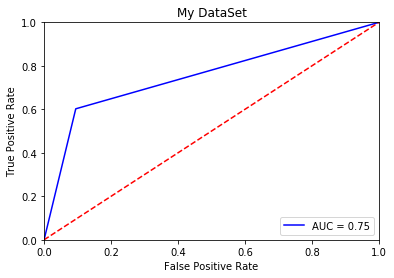

In [ ]:
value_of_metrics(y_test2,bern_train2.predict(X_test2))

In [ ]:
## Multi
multu_train2 = Multi_nb(X_train2, y_train2)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score: 0.8115759105661738
Best parameters: {'alpha': 0.2, 'fit_prior': 'True'}


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.0s finished


Accuracy:  0.7998918334234721
Recall:  0.8463251670378619
Precision:  0.7661290322580645
F1:  0.8042328042328042
Roc_AUC:  0.8011857170625692


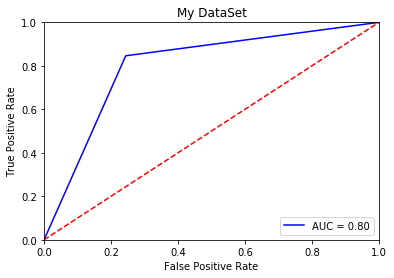

In [ ]:
value_of_metrics(y_test2,multu_train2.predict(X_test))

In [ ]:
logit2 = LogisticRegression()
logit2.fit(X_train2, y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy:  0.8042184964845862
Recall:  0.7293986636971047
Precision:  0.8462532299741602
F1:  0.7834928229665071
Roc_AUC:  0.8021336115541254


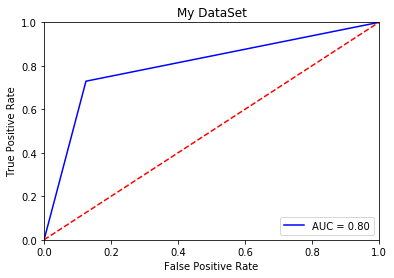

In [ ]:
value_of_metrics(y_test2,logit2.predict(X_test2))

In [ ]:
svm2 = LinearSVC()
svm2.fit(X_train2, y_train2)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Accuracy:  0.8009734991887507
Recall:  0.765033407572383
Precision:  0.8139810426540285
F1:  0.7887485648679678
Roc_AUC:  0.7999720139859813


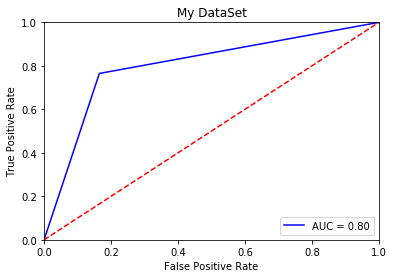

In [ ]:
value_of_metrics(y_test2,svm2.predict(X_test2))